<h1>GoT Finale Tweets Analysis<span class="tocSkip"></span></h1>

* Introduction
* Imports
* Getting old Tweets
* Cleaning the Feed
* Exploratory Data Analysis
    * Most retweeted
    * Most favourited
    * Most recent
    * Favourite & Retweet correlation
* Analysis
    * Hashtag
    * Topic
    * Sentiment
        * I. Train model using Cornell Movie Review Data
        * II. Train model using Apple Computers Twitter Sentiment
    * Topic & Sentiment analysis for each main character
* Next Steps

# Introduction

## Purpose of this notebook
The purpose of this notebook is to analyze what people tweeted about the final episode of Game of Thrones, which came out on May 19, 2019. 

## Prior work

Prior work: exploratory data analysis of the most current twitter data

## Guiding questions
* What are some common threads/topics in people's comments? 
* How did people generally feel about the final episode?
    * How did they feel about each character's ending?

## Key findings
* A lot of (about 1K) people are struggling with spelling #gameofthones #dan***? How do you spell this?
* The number of retweets are highly correlated with the number of favorites
* Most people mentioned Jon, followed by Bran and then Dany.
* Jon and Dany usually appear together in a tweet while Bran and Tyrion coexist
* Most people (about 78%) have negative sentiment towards the finale (Based on one model trained using pre-labeled twitter dataset. Another model trained using movie reviews suggests that all tweets are negative...)
* Seems like people are least unhappy about Sansa's ending (only 72% negative compared to other who are in the 80%s).

## Related notebooks

* **Related notebooks:** `Analyze-LiveStream.ipynb` 

# Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
from functools import reduce
import tarfile

In [40]:
import re, string
from nltk.tokenize import word_tokenize
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.stem.porter import PorterStemmer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk import pos_tag, bigrams

# Getting old Tweets
The data is acquired using the Makefile in the directory. Follow the README file to get all the data.
<br>Only 20K tweets that happened right after the finale aired were captured.

In [2]:
tweets = pd.read_csv("../data/raw/output_got.csv")

In [3]:
tweets.head()

,date,username,to,replies,retweets,favorites,text,geo,mentions,hashtags,id,permalink
0,2019-05-20 23:59:58,tpurvis06,NaN,0,0,0,You’ll never love #GameOfThrones as much as I ...,NaN,NaN,#GameOfThrones,1130624236232499200,https://twitter.com/tpurvis06/status/113062423...
1,2019-05-20 23:59:58,KrystalBClear7,NaN,0,0,0,They did Queen Dany dirtyyyyyyyy! #GameOfThrones,NaN,NaN,#GameOfThrones,1130624235347615746,https://twitter.com/KrystalBClear7/status/1130...
2,2019-05-20 23:59:57,Dynastiix,NaN,0,0,0,Bran is probably feeling really insecure about...,NaN,NaN,#GameOfThrones #GOTFinale,1130624232533254144,https://twitter.com/Dynastiix/status/113062423...
3,2019-05-20 23:59:56,alisonmccourt,NaN,0,0,4,I wouldn’t trade the 8 years of watch parties....,NaN,NaN,#GameOfThronesFinale #GameOfThrones,1130624226178850817,https://twitter.com/alisonmccourt/status/11306...
4,2019-05-20 23:59:55,sponzillotv,NaN,0,0,0,"#OverheardWhileDogWalking “Because, like, the ...",NaN,NaN,#OverheardWhileDogWalking #SheWasntWrong #Game...,1130624224819859457,https://twitter.com/sponzillotv/status/1130624...


In [4]:
things = ['text', 'date', 'retweets', 'geo', 'favorites', 'hashtags']

In [5]:
tweets = tweets[things]

In [6]:
tweets.shape

(20000, 6)

# Cleaning the feed

In [7]:
# drop duplicates posted seconds/minutes/hours away from each other
tweets = tweets.drop_duplicates([x for x in tweets.columns if x is not 'date'])

In [8]:
tweets.shape

(19983, 6)

In [9]:
# sum favorites & retweets
grouped_text = tweets.groupby("text").sum().reset_index()

In [10]:
# earliest date of post
grouped_date = tweets.groupby("text").date.min().reset_index()

In [11]:
ftweets = grouped_date.merge(grouped_text, on="text", how="left")

In [12]:
ftweets.shape

(19876, 5)

In [13]:
def saveAsCoord(x):
    try:
        return tuple(x['coordinates'])
    except:
        return 'NA'

In [21]:
ftweets['geo_cor'] = ftweets.geo.apply(saveAsCoord)

In [22]:
ftweets[ftweets.geo_cor != 'NA']

,text,date,retweets,geo,favorites,geo_cor


In [23]:
ftweets.isnull().sum()

text         0
date         0
retweets     0
geo          0
favorites    0
geo_cor      0
dtype: int64

- **only keep one for same content, different links**

In [17]:
def replaceLinks(x):
    while re.search("[pic]*?.twitter.com/[a-z\d]*", x.lower()) is not None:
        temp = re.search("[pic]*?.twitter.com/[a-z\d]*", x.lower())
        x = x.replace(x[temp.start(): temp.end()], "")
    return x

In [24]:
ftweets["no_links"] = ftweets.text.apply(replaceLinks)

In [25]:
ftweets.drop_duplicates([x for x in ftweets.columns if x not in ['text', 'date']], inplace=True)

In [277]:
test = ftweets.groupby("no_links").min().reset_index()

# Exploratory Data Analysis

## - Most Retweeted

In [279]:
for t in test.sort_values("retweets", ascending = False).head(5).text:
    print(t, "\n")

This video wins the internet today! #GameOfThrones pic.twitter.com/JCNfjpeq5E 

I'm not crying, you are. #GameOfThrones pic.twitter.com/FT9zqYOkEp 

An extraordinary journey. @Isaac_H_Wright #GameofThrones pic.twitter.com/mhV3pLUTDL 

Nothing sums up the snowflake generation more than this ridiculous petition to have the #GameofThrones final season rewritten. If they don't get what they want, whether it's Trump, Brexit or a TV show, they lie on the floor screaming 'I REFUSE TO ACCEPT THAT - DO IT AGAIN!!!!!' 

Mom... Mom... get up mom... #GameOfThrones #gotatlanticpic.twitter.com/ympeyepzyl 



> The 5th most retweeted tweet is about Dany but did not mention her name at all. (You can check out this page for the [content](pic.twitter.com/ympeyepzyl)). <br>There will be these tweets that my rule might not be able to capture.

## - Most Favorited

In [280]:
for t in test.sort_values("favorites", ascending = False).head(5).text:
    print(t, "\n")

An extraordinary journey. @Isaac_H_Wright #GameofThrones pic.twitter.com/mhV3pLUTDL 

This video wins the internet today! #GameOfThrones pic.twitter.com/JCNfjpeq5E 

Nothing sums up the snowflake generation more than this ridiculous petition to have the #GameofThrones final season rewritten. If they don't get what they want, whether it's Trump, Brexit or a TV show, they lie on the floor screaming 'I REFUSE TO ACCEPT THAT - DO IT AGAIN!!!!!' 

I'm not crying, you are. #GameOfThrones pic.twitter.com/FT9zqYOkEp 

THANK YOU !!!!! #gameofthrones #aryastarksequel #bestcastandcrew https://www.instagram.com/p/BxswpkslPpW/?igshid=b2ymoar0eer … 



> The most favorited tweet is about the actor who played Bran but did not mention the character's name. <br><br>There will be these tweets that my rule might not be able to capture.

## - Most Recent Tweets

In [281]:
for t in test.sort_values("date", ascending = False).head(5).text:
    print(t, "\n")

You’ll never love #GameOfThrones as much as I don’t... 

They did Queen Dany dirtyyyyyyyy! #GameOfThrones 

Bran is probably feeling really insecure about his manhood now because of Sansa's comment. His third eye dosent work. #GameOfThrones #GOTFinale 

I wouldn’t trade the 8 years of watch parties. I really wouldn’t. #GameOfThronesFinale #GameOfThrones 

#OverheardWhileDogWalking “Because, like, the Robin Arryn glowup is only because his mom died and like he could finally get vaccinated” Done. I’m just done. #SheWasntWrong #GameOfThrones 



## - Combine retweets & favorites since they are quite correlated

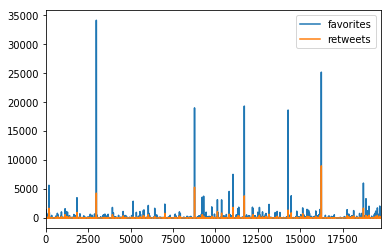

In [30]:
test[['favorites', 'retweets']].plot()

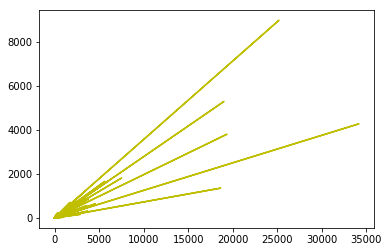

In [31]:
plt.plot(test.favorites, test.retweets, "y")

In [32]:
test[['favorites', 'retweets']].corr()

,favorites,retweets
favorites,1.000000,0.895553
retweets,0.895553,1.000000


In [282]:
test['popularity'] = test.favorites + test.retweets

## - Mentioning main characters

In [477]:
mains = ["|".join(['daenerys targaryen', "dany", "daenerys", "khaleesi", "mother of dragons", "motherofdragons", 
                   "danerys", "danaerys"]), 
         "|".join(['jon snow', 'jon']), 
         "|".join(['sansa stark', 'sansa']), 
         "|".join(['arya stark', 'arya']),
         "|".join(["bran stark", "brandon stark", "three-eyed raven", "bran"]),
         "|".join(['tyrion', 'tyrion lannister'])]

In [478]:
for char in mains:
    print(char[0],test[test.no_links.str.lower().str.contains(char)].shape[0])

d 1330
j 1588
s 622
a 756
b 1446
t 643


> Most people mentioned Jon, followed by Bran and then Dany.

### A glimpse of their most popular tweets

In [283]:
for x in test[test.no_links.str.lower().str.contains(mains[0])].sort_values("popularity", ascending=False).head(5).text:
    print(x, "\n")

Jon to Dany there at the end #GameOfThonesFinale #GameOfThrones #DemThronespic.twitter.com/n0czgoAvkz 

In S5 E2 Ser Barristan Selmy councils Daenerys to utilize restraint and warns her about following in her father’s footsteps #GameofThrones pic.twitter.com/utUm0TCiq3 

I’m just really hoping this is what’s going on in Dany’s afterlife after that mess of betrayal and loss she went through #GameOfThrones pic.twitter.com/YbQdofNUhJ 

Great CGI work! #Daenerys #Drogon #GameOfThrones pic.twitter.com/JaxPlk3a7r 

For what’s (hopefully!) my last #GameofThrones piece, I wrote about why Dany’s story ending on the “Jon & Tyrion Talk In Circles” show was so frustrating, and how hard Emilia Clarke crushed it, anyway. https://variety.com/2019/tv/columns/game-of-thrones-series-finale-dany-daenerys-death-mad-queen-1203221341/ … 



In [284]:
for x in test[test.no_links.str.lower().str.contains(mains[1])].sort_values("popularity", ascending=False).head(5).text:
    print(x, "\n")

Jon to Dany there at the end #GameOfThonesFinale #GameOfThrones #DemThronespic.twitter.com/n0czgoAvkz 

#GameofThrones >yara greyjoy won the kingsmoot but is anti democracy and fought for independence >prince of dorne has no idea wtf a 3 eyed raven is >gendry literal heir to the throne >jon snow also literally the heir to the throne tyrion: lets vote for bran lords of westeros: pic.twitter.com/IsKXS62kUy 

For what’s (hopefully!) my last #GameofThrones piece, I wrote about why Dany’s story ending on the “Jon & Tyrion Talk In Circles” show was so frustrating, and how hard Emilia Clarke crushed it, anyway. https://variety.com/2019/tv/columns/game-of-thrones-series-finale-dany-daenerys-death-mad-queen-1203221341/ … 

#GameOfThrones questions... • Where did Drogon go? • How did all those rocks not severely damage Jaime & Cersei’s heads? • Who the hell is Jon going to watch for at The Wall? • Why does Bran need a master of whisperers? pic.twitter.com/8MrXh2tDMK 

So what's the point of brin

## - Try seperating Spanish into its own
using #juegodetronos

In [285]:
spanish = test[test.text.str.contains("#juegodetronos")]

In [286]:
test = test[~test.text.str.contains("#juegodetronos")].reset_index(drop=True)

# Analysis

# - Hashtags Analysis

In [41]:
def findHashtags(x):
    new = re.findall("#[a-z]*", x.lower())
    return new

In [42]:
new = test.text.apply(findHashtags)

In [43]:
all_words = []

In [44]:
all_words = reduce(lambda x, y: x+y, new.values.tolist())

In [45]:
hashtags = list(set(all_words))

In [46]:
check = sorted(hashtags, key=len, reverse=True)

In [47]:
hash_counts = [(k,v) for k,v in Counter(all_words).items()]

In [48]:
sorted_x = sorted(dict(hash_counts).items(), key=lambda kv: kv[1])

In [49]:
sorted_x[-10:]

[('#thefinalepisode', 261),
 ('#gotseasonfinale', 261),
 ('#jonsnow', 336),
 ('#gots', 342),
 ('#gameofthronesfinalepic', 344),
 ('#gotfinale', 713),
 ('#gameofthonesfinale', 1147),
 ('#gameofthronesfinale', 1807),
 ('#got', 2301),
 ('#gameofthrones', 19792)]

### -> Most used hashtags

Text(0.5, 1.0, 'Number of Mentions for the Top 10 Hashtags')

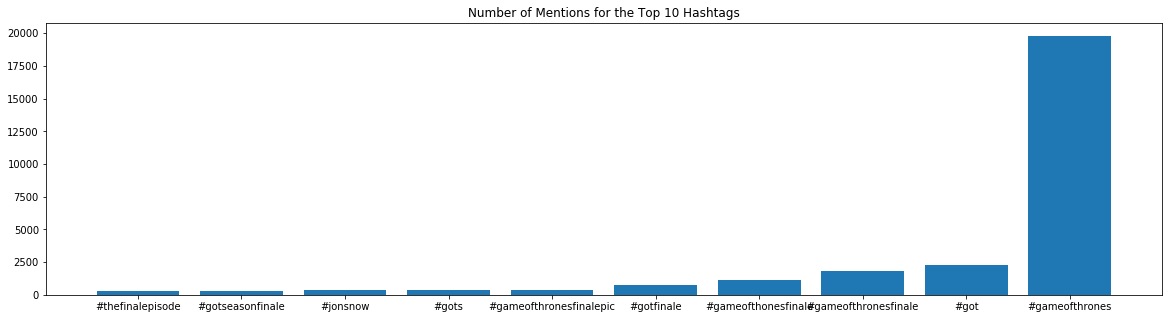

In [50]:
plt.figure(figsize=(20,5))
plt.bar([x[0] for x in sorted_x[-10:]], [x[1] for x in sorted_x[-10:]])
plt.title("Number of Mentions for the Top 10 Hashtags")

> A lot of (about 1K) people are struggling with spelling. #gameofthones

# - Topic Analysis

In [52]:
# Create a WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

In [233]:
# Use Porter stemmer
stemmer = PorterStemmer()

In [53]:
# create English stop words list (you can always define your own stopwords)
stop_words = set(stopwords.words('english'))

In [201]:
# Function to remove stop words from sentences & lemmatize verbs and nouns. 
def clean(doc, lem = True):
    # treat xx's as xxs
    doc = doc.replace("'s", "s")
    # tokenize
    tokenized = word_tokenize(doc.lower())
    # remove punctuations (’ included) and stopwords
    stop_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + '’]+', x) and x not in stop_words]
    if lem:
        lemma_verb = [lemmatizer.lemmatize(word,'v') for word in stop_free]
        lemma_noun = [lemmatizer.lemmatize(word,'n') for word in lemma_verb]
        #y = [s for s in lemma_noun if len(s) > 2]
        return lemma_noun
    else:
        return stop_free

**Step 1: Clean the corpus**
- convert the text reviews to lowercase
- remove #gameofthrones (every tweet has it)
- remove reviews with less than 3 tokens

In [55]:
def removeHashtags(x):
    for i in range(len(check)-1):
        hashed = check[i]
        try:
            x = x.lower().replace(hashed, "")
        except:
            next
    return x

In [56]:
links = re.compile('[https?]*?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+[/?\w+=?\w+]*')
def removeLinks(x):
    while re.search(links, x.lower()) is not None:
        temp = re.search(links, x.lower())
        x = x.replace(x[temp.start(): temp.end()], "")
    return x

In [291]:
# clean text one step at a time
test['pure_text'] = test.text.apply(removeHashtags)
test['pure_text'] = test.pure_text.apply(replaceLinks)
test['pure_text'] = test.pure_text.apply(removeLinks)

In [62]:
review = test.pure_text.values.tolist()

In [63]:
long_review = [x for x in review if len(x) > 3]

In [64]:
len(review), len(long_review)

(19726, 19726)

- tokenize them
- remove punctuations, and stop words.
- filter the terms which occurred less than 10 times in your documents (i.e., reviews).
- with and without lemmatization

In [202]:
# with lemmatization
skim_review = [clean(doc.strip()) for doc in long_review]

**Step 2: Create the dictionary**

only exploring dictionary with lemmatization

In [203]:
freq = [(k,v) for k,v in Counter([item for sublist in skim_review for item in sublist]).items() 
        if v >= 10 and re.search('\d+', k) is None]

dictionary = [x[0] for x in freq]

**Step 3: DT**

Convert the list of documents in your corpus into Document-Term Matrix using the dictionary prepared at Step 2 (again, a term is a word).

-With lemmatization

In [204]:
Dic = corpora.Dictionary([dictionary])
corpus = [Dic.doc2bow(doc_clean) for doc_clean in skim_review]

**Step 4: Run the LDA model on the document-term matrix**
    
LDA with the following parameters: number of topics (k = 10), number of passes (pass = 20), and number of iterations (iterations = 2000).

-With lemmatization

In [205]:
# LDA model needs many iterations/passes and a large corpus to work well
# must define the number of topics you want to extract from the corpus
ldamodel = LdaModel(corpus, num_topics=7, id2word = Dic, passes=20, iterations=2000)

**Step 5: For each of the k topics, print the top 10 words**

In [206]:
ori_tops = ldamodel.print_topics(num_topics=7, num_words=10)

In [207]:
pd.DataFrame([re.findall("\"\w*[.']?\w*\"", x[1]) for x in ori_tops])\
    .rename(index=dict(zip(range(5), ["topic"+str(x) for x in range(5)])),
            columns=dict(zip(range(10), ["word_"+str(x) for x in range(10)])))

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
topic0,"""thank""","""show""","""amaze""","""love""","""one""","""character""","""make""","""perfect""","""u""","""work"""
topic1,"""throne""","""game""","""finale""","""spoiler""","""hbo""","""watch""","""season""","""series""","""fan""",None
topic2,"""jon""","""queen""","""snow""","""dany""","""drogon""","""dragon""","""north""","""daenerys""","""get""","""kill"""
topic3,"""book""","""like""","""people""","""story""","""see""","""two""","""look""","""get""",None,None
topic4,"""end""","""n't""","""watch""","""show""","""season""","""series""","""ever""","""'m""","""episode""","""finale"""
5,"""bran""","""king""","""tyrion""","""arya""","""break""","""westeros""","""na""","""stark""","""new""","""one"""
6,"""season""","""get""","""last""","""episode""","""like""","""end""","""fuck""","""well""","""watch""","""think"""


> Some people are grateful (topic 0). <br>Jon and Dany coexist (topic 2) while Bran and Tyrion coexist (topic 5). <br>Some people have very strong feelings (topic 6).

# - Sentiment Analysis

## I. Train model using [Cornell Movie Review Data](https://www.cs.cornell.edu/people/pabo/movie-review-data/)

In [410]:
def clean_review(review, stem=False):
    """Clean a passed in review
    
    Tokenizes and removes punctuation, with the option of stemming
    
    Args:
        review (str): movie review text string
        stem (boolean): indicator whether to stem or just tokenize
        
    Returns:
        clean_review (list): tokenized, cleaned movie review
    """
    # Remove styling
    review = review.replace("'s", "s")
    review = word_tokenize(review)
    if stem:
        stemmer = PorterStemmer()
        review = [stemmer.stem(token) for token in review]
    # Remove punctuation
    cleaned_review = [x for x in review if not re.fullmatch('[' + string.punctuation + '’]+', x)]
    return cleaned_review

In [161]:
def show_most_informative_features(vectorizer, classifier, n=10):
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()  
    topn_pos_class = sorted(zip(classifier.feature_count_[1], feature_names),reverse=True)[:n]
    topn_neg_class = sorted(zip(classifier.feature_count_[0], feature_names),reverse=True)[:n]    

    print("Important words in positive reviews")
    for coef, feature in topn_pos_class:
        print(class_labels[1], coef, feature) 
    print("-----------------------------------------")
    print("Important words in negative reviews")
    for coef, feature in topn_neg_class:
        print(class_labels[0], coef, feature)

In [129]:
train_pos_file_list = []
train_neg_file_list = []
test_pos_file_list = []
test_neg_file_list = []
with tarfile.open("../data/raw/review_polarity.tar.gz") as f:
    for member in f.getmembers():
        # skip README file
        if member.name == 'poldata.README.2.0':
            next
        else:
            file=f.extractfile(member)
            content=file.read()
            if 'pos' in member.name:
                if int(member.name[19:22]) >= 800:
                    test_pos_file_list.append(content)
                else:
                    train_pos_file_list.append(content)
            else:
                if int(member.name[19:22]) >= 1800:
                    test_neg_file_list.append(content)
                else:
                    train_neg_file_list.append(content)

In [131]:
train_pos_labels = [1 for i in range(len(train_pos_file_list))]
train_neg_labels = [0 for i in range(len(train_neg_file_list))]
test_pos_labels = [1 for i in range(len(test_pos_file_list))]
test_neg_labels = [0 for i in range(len(test_neg_file_list))]

In [132]:
train_labels = train_pos_labels + train_neg_labels
test_labels = test_pos_labels + test_neg_labels

In [148]:
train_pos_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in train_pos_file_list]
train_neg_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in train_neg_file_list]
test_pos_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in test_pos_file_list]
test_neg_file_list = [str(text).replace("b'", "").replace("\\n","").replace("\\'","'") for text in test_neg_file_list]

In [149]:
train_file_list = train_pos_file_list + train_neg_file_list
test_file_list = test_pos_file_list + test_neg_file_list

In [309]:
train = [clean_review(review) for review in train_file_list]
ttest = [clean_review(review) for review in test_file_list]

Multiple methods are entertained, but having adj/v features perform the best / has the highest accuracy:
    1. absent/present words (68.5%)
    2. term frequency (72.5%)
    3. POS tagging (adj/v) (73.5%)
    4. tf-idf (51%)
    5. bi-grams (67%)

- M2: term frequency

In [310]:
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([' '.join(review) for review in train])
test_features = vectorizer.transform([' '.join(review) for review in ttest])
nb_clf = MultinomialNB()
nb_clf.fit(train_features, train_labels)
predictions = nb_clf.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
accuracy

0.725

In [311]:
class_labels = nb_clf.classes_
show_most_informative_features(vectorizer, nb_clf)

Important words in positive reviews
1 33040.0 the
1 15818.0 and
1 14844.0 of
1 13119.0 to
1 11428.0 is
1 9282.0 in
1 6761.0 it
1 6517.0 that
1 5193.0 as
1 4753.0 with
-----------------------------------------
Important words in negative reviews
0 35058.0 the
0 15680.0 and
0 15487.0 of
0 15420.0 to
0 11626.0 is
0 10097.0 in
0 7803.0 that
0 7756.0 it
0 4941.0 with
0 4930.0 this


In [167]:
def clean_pos(tokenized, stem=False):
    punctuation_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x)]
    word_posTags = pos_tag(punctuation_free)
    # get adjv words by the POS tags
    adjv_words = [x[0] for x in word_posTags if len(re.findall('(RB\w*|JJ\w*)', x[1]))>0]
    # presence/absence
    unique_adjv_words = list(set(adjv_words))
    if stem:
        stemmedWords = []
        for word in unique_adjv_words:
            try:
                a = stemmer.stem(word)
                stemmedWords.append(a)
            except:
                next
        return ' '.join(stemmedWords)
    else:
        return ' '.join(unique_adjv_words)

- M3: POS advj

In [312]:
vectorizer = CountVectorizer()
train_features = vectorizer.fit_transform([clean_pos(review) for review in train])
test_features = vectorizer.transform([clean_pos(review) for review in ttest])
nb_clf = MultinomialNB()
nb_clf.fit(train_features, train_labels)
predictions = nb_clf.predict(test_features)
accuracy = accuracy_score(test_labels, predictions)
accuracy

0.735

In [313]:
class_labels = nb_clf.classes_
show_most_informative_features(vectorizer, nb_clf)

Important words in positive reviews
1 700.0 not
1 600.0 more
1 577.0 when
1 564.0 so
1 538.0 well
1 519.0 most
1 511.0 just
1 497.0 even
1 492.0 only
1 487.0 good
-----------------------------------------
Important words in negative reviews
0 854.0 not
0 769.0 so
0 732.0 when
0 719.0 more
0 694.0 only
0 686.0 just
0 674.0 even
0 596.0 good
0 571.0 much
0 534.0 most


- **Use the model on all tweets**

In [325]:
tweet_features = vectorizer.transform([clean_pos(t) for t in review])
t_predictions = nb_clf.predict(tweet_features)

In [326]:
sum(t_predictions)

0

> This model thinks that all GoT tweets are negative. <br><br>Though likely, we would like to get some more nuanced answers. Maybe if the training set is more similar to our twitter dataset, then the result would be better.

## II. Train model using [Apple Computers Twitter Sentiment](https://www.figure-eight.com/data-for-everyone/)

In [338]:
sample = pd.read_csv("../data/raw/twitter_input.csv", encoding = "ISO-8859-1")

In [329]:
sample.shape

(3886, 12)

In [375]:
sample.head(3)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,5.400000e+17,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,5.400000e+17,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...


In [339]:
sample = sample[sample.sentiment != "not_relevant"]

In [341]:
sample['sentiment'] = sample.sentiment.apply(int)

In [369]:
sample.sentiment.value_counts()

3    2162
1    1219
5     423
Name: sentiment, dtype: int64

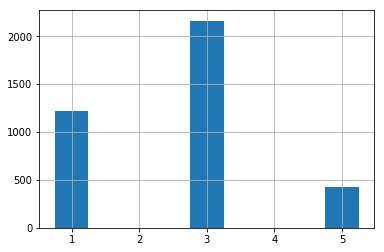

In [364]:
sample.sentiment.hist(bins = np.arange(1,6,0.5), align = 'left')

### Look into all 3 sentiments

In [373]:
for x in sample[sample.sentiment == 1].head().text:
    print(x)

WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW IS 29% WTF IS THIS @apple
@apple Contact sync between Yosemite and iOS8 is seriously screwed up. It used to be much more stable in the past. #icloud #isync
WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM @APPLE IPHONE YOU CANNOT USE IT ON VERIZON NETWORK
@Apple, For the love of GAWD, CENTER the '1'on the damn calendar app. You fixed it once, its back, off center, AGAIN! http://t.co/dMyAHEm1Lc
i get the storage almost full notification literally every 5 minutes chill @apple


In [374]:
for x in sample[sample.sentiment == 5].head().text:
    print(x)

Top 3 all @Apple #tablets. Damn right! http://t.co/RJiGn2JUuB
CNBCTV: #Apple's margins better than expected? #aapl http://t.co/7geVrtOGLK
RT @peterpham: Bought my @AugustSmartLock at the @apple store..pretty good logo match . can't wait to install it! http://t.co/z8VKMhbnR3
Latest Apple Products Leading in Efficiency http://t.co/KHeNlVT1FJ @apple #iPhone #iPad #plugloads
RT @saxonidubom: @rwang0 @Apple Thanks...thinking of upgrading.


In [372]:
for x in sample[sample.sentiment == 3].head().text:
    print(x)

#AAPL:The 10 best Steve Jobs emails ever...http://t.co/82G1kL94tx
RT @JPDesloges: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL #aapl
http://t.co/hGFcjYa0E9
My cat only chews @apple cords. Such an #AppleSnob.
I agree with @jimcramer that the #IndividualInvestor should own not trade #Apple #AAPL, it's extended so today's pullback is good to see
Nobody expects the Spanish Inquisition #AAPL


> Sentiment score 3s are indeed quite neutral. So there should be 3 classes: negative, positve, neural.

### Step 1: Clean data
Though because of the cleaning process, all the all caps tweets will be converted to lower cases.

In [376]:
# clean text one step at a time
sample['pure_text'] = sample.text.apply(removeHashtags)
sample['pure_text'] = sample.pure_text.apply(replaceLinks)
sample['pure_text'] = sample.pure_text.apply(removeLinks)

In [378]:
ats = re.compile('@\w*')
def removeAts(x):
    while re.search(ats, x.lower()) is not None:
        temp = re.search(ats, x.lower())
        x = x.replace(x[temp.start(): temp.end()], "")
    return x

In [380]:
sample['pure_text'] = sample.pure_text.apply(removeAts)

In [381]:
sample.pure_text.head()

0            apl:the 10 best steve jobs emails ever...
1    rt : why aapl stock had a mini-flash crash tod...
2              my cat only chews  cords. such an snob.
3    i agree with  that the dividualinvestor should...
4           nobody expects the spanish inquisition apl
Name: pure_text, dtype: object

### Step 2: Stratified Sampling

In [382]:
from sklearn.model_selection import train_test_split

In [383]:
X = sample.pure_text.values

In [384]:
y = sample.sentiment.values

In [385]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

### Step 3: Train Models

In [426]:
vectorizer = CountVectorizer()
t_train_features = vectorizer.fit_transform([' '.join(clean_review(review)) for review in X_train])
t_test_features = vectorizer.transform([' '.join(clean_review(review)) for review in X_test])
t_nb_clf = MultinomialNB()
t_nb_clf.fit(t_train_features, y_train)
t_predictions = t_nb_clf.predict(t_test_features)
t_accuracy = accuracy_score(y_test, t_predictions)
t_accuracy

0.7237261146496815

In [427]:
t_class_labels = t_nb_clf.classes_
show_most_informative_features(vectorizer, t_nb_clf)

Important words in positive reviews
3 664.0 the
3 550.0 apl
3 470.0 in
3 374.0 apple
3 366.0 rt
3 345.0 to
3 320.0 is
3 315.0 of
3 205.0 at
3 190.0 aapl
-----------------------------------------
Important words in negative reviews
1 350.0 the
1 280.0 to
1 238.0 my
1 189.0 is
1 166.0 you
1 154.0 it
1 144.0 of
1 140.0 on
1 129.0 and
1 127.0 rt


- Other models such as POS adj performed worse, with an accuracy of 11.78%

### Step 4: Use the model on all tweets

In [420]:
cleaned_review = [" ".join(clean_review(t)) for t in review]

In [428]:
tweet_features = vectorizer.transform(cleaned_review)
new_predictions = t_nb_clf.predict(tweet_features)

In [469]:
for num in [1,3,5]:
    print(num, ":", 
          "{:2f}%".format(len(np.where(new_predictions == num)[0])/len(new_predictions)*100),
          len(np.where(new_predictions == num)[0]))

1 : 77.760316% 15339
3 : 19.796208% 3905
5 : 2.443476% 482


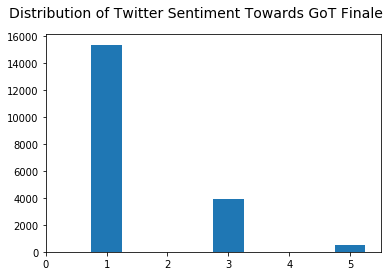

In [459]:
plt.hist(new_predictions, bins = np.arange(.5,6,.5), align="left")
plt.title("Distribution of Twitter Sentiment Towards GoT Finale", fontsize = 14).set_position([0.45, 1.05])

> Most of the people (78%) have negative sentiment towards the Game of Thrones finale.

In [505]:
for x in test.iloc[np.where(new_predictions == 1)[0],:].text.sample(5<br>):
    print(x, "\n")

Dues Ex Fuck-It-Up. #GameOfThrones #DemThrones 

What was the point of Jon's reasurrection? What was the point of his parentage? What was the point of the Three Eyed Raven? What was the point of the White Walkers? #GameOfThrones 

I can't breathe, this is so accurate Absolute mixed feelings about that ending. Still processing... #GameofThrones https://twitter.com/SiddanthKamble/status/1130387819497545728 … 

The first dragon forged it. The last dragon destroyed it. #GameofThrones #TheFinalEpisode 

The #GameofThrones finale was awesome. I loved every bit of it. 



> After sampling some tweets classified as negative, it seems that most are valid (e.g. Dues Ex Fuck-It-Up.) but some seems off (e.g. The #GameofThrones finale was awesome. I loved every bit of it.). <br><br>Moreover, the negative feeling are not one-dimensional, it can be frustration, grief, or anger.

In [509]:
for x in test.iloc[np.where(new_predictions == 5)[0],:].text.sample(5):
    print(x, "\n")

So basically Jon Snow pulled a Dexter and became a lumberjack. Great job guys. #GameOfThrones 

I liked the Game Of Thrones season 8 finale. Great ending to a great season and TV show #GameOfThrones 

Ghost is a good boy and waited long enough. Brienne's performance review scene was great, too. And Drogon the diplomat! Aaah I'll miss that show. #GameOfThrones 

Almost (with more episodes, and less easy comedy moments...) but YES, best ending they could give to #GameOfThrones https://twitter.com/PedroPascal1/status/1130298793545437184 … 

drogon's cries were pure pain. he and dany were so connected. he always watched out for her. i'm heartbroken for the both of them #GameOfThrones #TheFinalEpisodepic.twitter.com/EWt1nCS0Vj 



> Some goes with tweets classified as positive. Many make sense but some are not so valid (e.g. i'm heartbroken for the both of them). 

# - Topic & Sentiment Analysis for each character

In [273]:
def removeDany(x, char):
    for name in char.split("|"):
        x = x.replace(name, "")
    x = x.replace("'s", "s")
    return x

In [296]:
def getCharTopics(char, Dic = Dic, n_topics = 5):
    """
    Args:
        char (str): one of the mains
    """
    ## Step 1: clean
    # filter down to the character
    char_tweets = test[test.no_links.str.lower().str.contains(char)]
    # remove the character name (which will show up a lot, thus skewing topics)
    char_review = char_tweets.pure_text.apply(lambda x: removeDany(x, char)).values.tolist()
    # with lemmatization
    d_review = [clean(doc.strip()) for doc in char_review]
    # build new corpus with only the character related tweets
    d_corpus = [Dic.doc2bow(doc_clean) for doc_clean in d_review]
    # create LDA model
    d_ldamodel = LdaModel(d_corpus, num_topics=n_topics, id2word = Dic, passes=20, iterations=2000)
    d_tops = d_ldamodel.print_topics(num_topics=n_topics, num_words=10)
    topics = pd.DataFrame([re.findall("\"\w*[.']?\w*\"", x[1]) for x in d_tops])\
            .rename(index=dict(zip(range(n_topics), ["topic"+str(x) for x in range(n_topics)])),
                    columns=dict(zip(range(10), ["word_"+str(x) for x in range(10)])))
    return char_review, topics

In [473]:
def sentimentAnalysis(review, plot = True):
    cleaned_review = [" ".join(clean_review(t)) for t in review]

    tweet_features = vectorizer.transform(cleaned_review)
    new_predictions = t_nb_clf.predict(tweet_features)

    for num in [1,3,5]:
        print(num, ":", 
              "{:2f}%".format(len(np.where(new_predictions == num)[0])/len(new_predictions)*100),
              len(np.where(new_predictions == num)[0]))
    if plot:
        plt.hist(new_predictions, bins = np.arange(.5,6,.5), align="left")
        plt.title("Distribution of Twitter Sentiment Towards GoT Finale", fontsize = 14).set_position([0.45, 1.05])
        plt.show()

## *Topic Analysis*

In [297]:
jon_review, jon_topics = getCharTopics(mains[1])
jon_topics

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
topic0,"""say""","""know""","""end""","""love""","""life""","""kill""","""n't""","""one""","""ever""","""live"""
topic1,"""king""","""bran""","""queen""","""n't""","""sansa""","""become""","""dany""","""north""","""know""","""kill"""
topic2,"""throne""","""game""","""dany""","""kill""","""like""","""would""","""know""",None,None,None
topic3,"""end""","""ghost""","""get""","""better""","""finale""","""deserve""","""episode""","""like""","""happy""","""season"""
topic4,"""end""","""go""","""king""","""north""","""watch""","""night""","""targaryen""","""get""","""arya""","""season"""


In [483]:
dany_review, dany_topics = getCharTopics(mains[1])
dany_topics

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
topic0,"""go""","""kill""","""end""","""king""","""dany""","""n't""","""night""","""watch""","""get""","""arya"""
topic1,"""end""","""dany""","""n't""","""ghost""","""deserve""","""better""","""get""","""know""","""give""","""pet"""
topic2,"""season""","""kill""","""know""","""get""","""targaryen""","""end""","""bran""","""would""","""like""","""king"""
topic3,"""end""","""north""","""arya""","""sansa""","""throne""","""get""","""king""","""want""","""queen""",None
topic4,"""king""","""throne""","""bran""","""queen""","""love""","""tyrion""","""game""",None,None,None


In [ ]:
d_review = [clean(doc.strip()) for doc in dany_review]

In [216]:
[(k,v) for k,v in Counter([item for sublist in d_review for item in sublist]).items() 
        if v >= 10][:5]

[('jon', 336), ('end', 265), ('ser', 11), ('council', 13), ('follow', 14)]

In [480]:
sansa_review, sansa_topics = getCharTopics(mains[2])
sansa_topics

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
topic0,"""queen""","""north""","""bran""","""jon""","""king""","""arya""","""end""","""n't""","""become""","""kingdom"""
topic1,"""get""","""bran""","""jon""","""end""","""arya""","""king""","""queen""","""go""","""tell""","""n't"""
topic2,"""sit""","""get""","""last""","""uncle""","""arya""","""fuck""","""jon""","""episode""","""bran""",None
topic3,"""best""","""game""","""one""","""like""","""throne""","""look""","""'m""","""girl""","""talk""",None
topic4,"""look""","""go""","""arya""","""like""","""jon""","""get""","""end""",None,None,None


In [490]:
tyrion_review, tyrion_topics = getCharTopics(mains[5])
tyrion_topics

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
topic0,"""bran""","""king""","""love""","""get""","""break""","""lannister""","""game""","""want""",None,None
topic1,"""one""","""brothel""","""honeycomb""","""jackass""","""speak""","""show""","""chair""","""time""","""series""","""bring"""
topic2,"""peter""","""dinklage""","""season""","""lannister""","""see""","""n't""","""go""","""one""","""character""","""hand"""
topic3,"""jon""","""say""","""bran""","""kill""","""know""","""get""","""end""","""arya""","""story""","""king"""
topic4,"""king""","""bran""","""would""","""end""","""think""","""like""","""one""","""show""","""watch""",None


In [492]:
arya_review, arya_topics = getCharTopics(mains[3])
arya_topics

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
topic0,"""get""","""na""","""bran""","""gon""","""know""","""would""","""episode""","""jon""","""n't""","""last"""
topic1,"""get""","""end""","""jon""","""sansa""","""go""","""cersei""","""dany""","""tyrion""","""n't""","""kill"""
topic2,"""jon""","""king""","""kill""","""new""","""like""","""become""","""bran""","""make""","""end""","""queen"""
topic3,"""west""","""westeros""","""go""","""end""","""one""","""throne""","""know""","""jon""","""would""",None
topic4,"""sansa""","""get""","""jon""","""end""","""go""","""like""","""north""","""want""","""adventure""","""queen"""


In [480]:
sansa_review, sansa_topics = getCharTopics(mains[2])
sansa_topics

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9
topic0,"""queen""","""north""","""bran""","""jon""","""king""","""arya""","""end""","""n't""","""become""","""kingdom"""
topic1,"""get""","""bran""","""jon""","""end""","""arya""","""king""","""queen""","""go""","""tell""","""n't"""
topic2,"""sit""","""get""","""last""","""uncle""","""arya""","""fuck""","""jon""","""episode""","""bran""",None
topic3,"""best""","""game""","""one""","""like""","""throne""","""look""","""'m""","""girl""","""talk""",None
topic4,"""look""","""go""","""arya""","""like""","""jon""","""get""","""end""",None,None,None


## *Sentiment Analysis*

In [299]:
def returnAdj(words):
    words = words.replace("'s", "s")
    words = words.replace("not ", "not_")
    words = word_tokenize(words)
    punctuation_free = [x for x in words if not re.fullmatch('[' + string.punctuation + '’]+', x)]
    #punctuation_free = [lemmatizer.lemmatize(word) for word in punctuation_free]
    word_posTags = pos_tag(punctuation_free)
    adj_words = [x[0] for x in word_posTags if x[1] in ['JJ','JJR','JJS']]
    return adj_words

In [301]:
def getTopAdj(reviews, n = 10, chart = True):
    # only get adjectives
    d_adj = [returnAdj(x) for x in reviews]
    # count occurrences
    d_adj_list = [(k,v) for k,v in Counter(list(reduce(lambda x, y: x+y, d_adj))).items() 
        if v >= 10 and re.search('\d+', k) is None and len(k) > 1]
    # take top n
    ranked = sorted(dict(d_adj_list).items(), key=lambda kv: kv[1], reverse=True)[:n]
    if chart:
        plt.figure(figsize=(10,5))
        plt.bar([x[0] for x in ranked], [x[1] for x in ranked])
        plt.title("Top {} Adjectives in the Tweets".format(n))
        plt.show()
    return ranked

#### Dany Targaryen

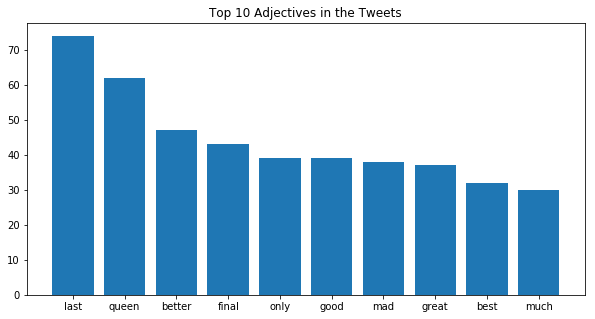

In [270]:
drank = getTopAdj(dany_review)

1 : 79.548872% 1058
3 : 18.120301% 241
5 : 2.330827% 31


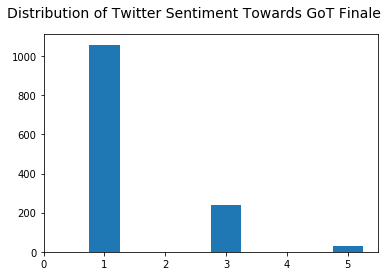

In [474]:
sentimentAnalysis(dany_review)

#### Jon Snow

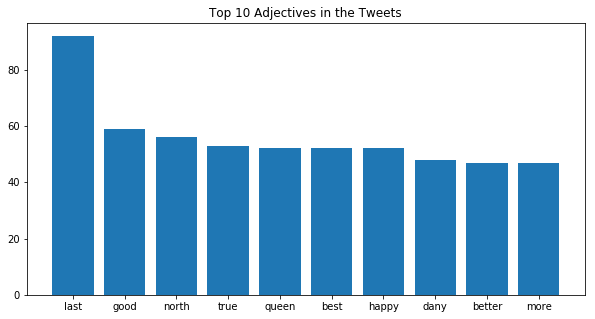

In [302]:
jrank = getTopAdj(jon_review)

1 : 80.982368% 1286
3 : 16.435768% 261
5 : 2.581864% 41


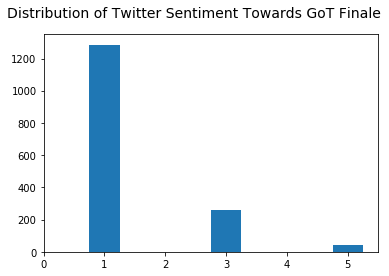

In [475]:
sentimentAnalysis(jon_review)

#### Sansa Stark

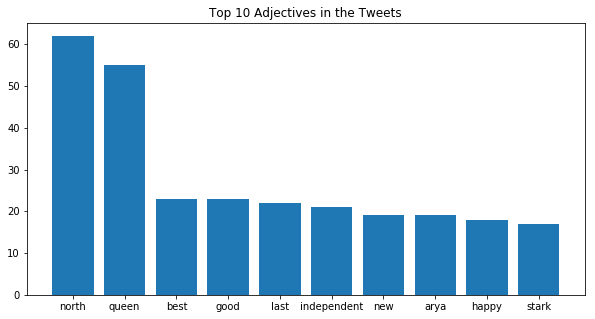

In [481]:
srank = getTopAdj(sansa_review)

1 : 72.186495% 449
3 : 24.598071% 153
5 : 3.215434% 20


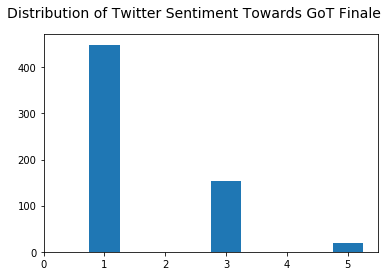

In [482]:
sentimentAnalysis(sansa_review)

#### Bran Stark

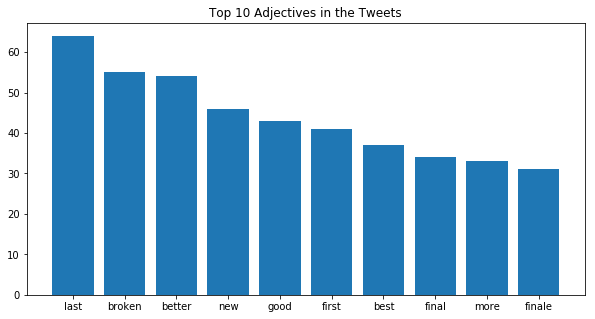

In [487]:
brank = getTopAdj(bran_review)

1 : 80.221300% 1160
3 : 17.980636% 260
5 : 1.798064% 26


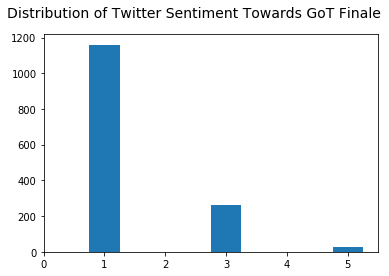

In [488]:
sentimentAnalysis(bran_review)

#### Arya Stark

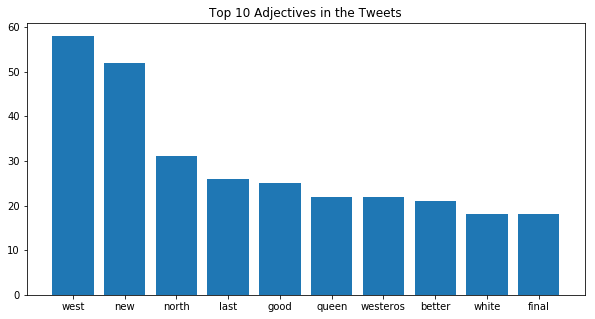

In [493]:
arank = getTopAdj(arya_review)

1 : 74.338624% 562
3 : 23.280423% 176
5 : 2.380952% 18


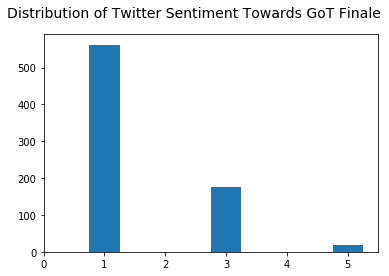

In [494]:
sentimentAnalysis(arya_review)

#### Tyrion Lannister

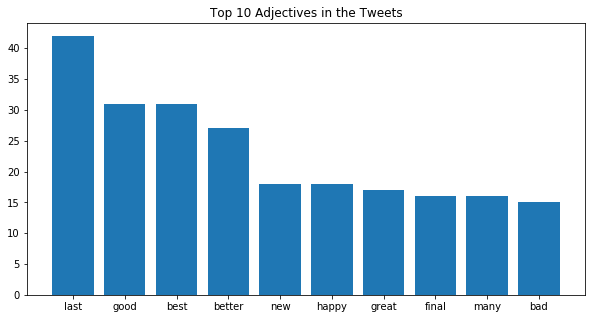

In [495]:
trank = getTopAdj(tyrion_review)

1 : 78.849145% 507
3 : 17.884914% 115
5 : 3.265941% 21


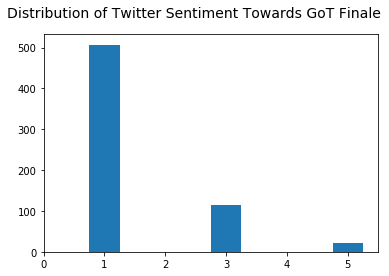

In [496]:
sentimentAnalysis(tyrion_review)

> Seems like people are least unhappy about Sansa's ending (only 72% negative compared to other who are in the 80%s).

# Next Steps

* As is seen while reading into the results of the sentiment analysis, some classifications are not so valid. Another dataset/a better approach can be used to build the sentiment analysis model so that the classification can be more accurate.
* The tweets about the finale differ a bit compared to the GoT live stream analysis. It can be interesting to track people's sentiment towards the show over time.